# Part B Recurrent Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from wordcloud import WordCloud

## Checking GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting Random Seed

In [4]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## Problem Statement
Our Goal of this project is to build a next-word predictor, given a sequence of words. Our model should also produce different sequences of words given the same input.
## Goals of this project
### Generalization
> We need a model that generalizes well to different input sequences beyond the training data.
### Accuracy of Predictions
> We need to make our model accurately predicts the next word in a given sequence, especially for the provided seed_texts. Idealy around 85% of our choosen evaluation metrics
### Variabilty in Output
> We need to create a model that is capable of producing different and diverse sequences for the same input.

# Importing Dataset

In [5]:
df = pd.read_csv('./datasets/train (1).csv')
print(df)

                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]


In [10]:
print(f'There are {len(df)} quotes in this dataset.')
df.head(5)

There are 1000 quotes in this dataset.


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."


## EDA
What insights can we get from our data?
- What is the frequency distribution of words in our dataset?
- What is the distribution of lengths of quotes from our dataset? Are there any outliers?

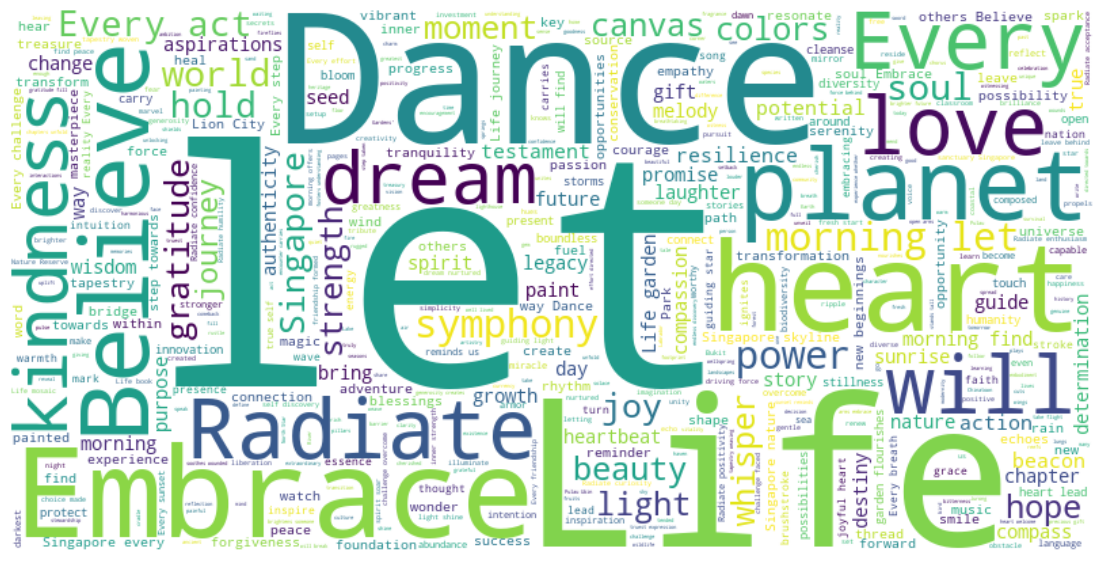

In [28]:
text = " ".join(quote for quote in df.Quotes)

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=5000).generate(text)

# Display the generated image
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observations:
- We can see that the words, "Let" , "Life" , "Embrace" and "Dance" are the most common words found in our dataset. 
- As wordcloud automatically removes common stopswords like "the" "and" "is"  to focus on meaningful words and avoid cluttering the visualization with frequently occurring but less informative words.

<Figure size 1400x800 with 0 Axes>

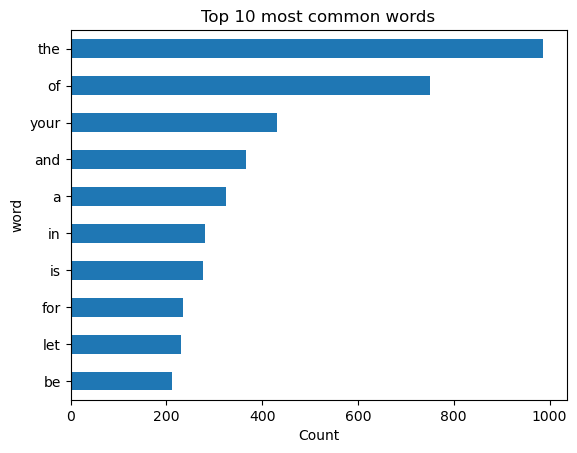

In [24]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Quotes'])
word_counts = tokenizer.word_counts
common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(14,8))
df_common_words.sort_values(by='count').plot(kind='barh', x='word', y='count', legend=False,)
plt.xlabel('Count')
plt.title('Top 10 most common words')
plt.show()

Observations:
- The most frequent words are now the common stopwords like "the", "of", "your" and "and". 
- Without wordcloud automatically removing them we can see that all of the top 10 most common words found in our dataset are stop words.

In [31]:
num_unique_words = len(tokenizer.word_index) + 1 # +1 for padding
print(f'Number of unique words: {num_unique_words}')

Number of unique words: 1199


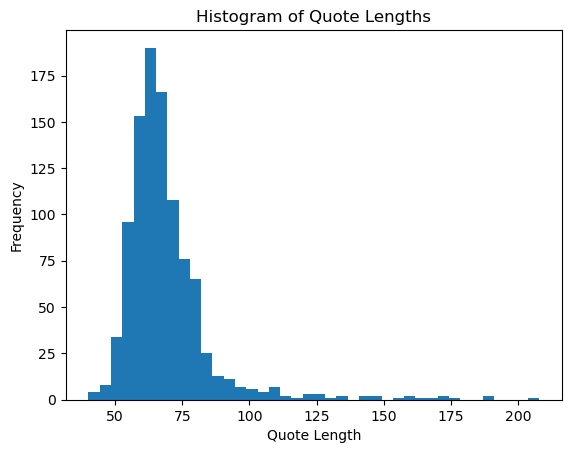

In [36]:
df['quote_length'] = df['Quotes'].apply(len)

# Create a histogram of quote lengths
df['quote_length'].plot(kind='hist', bins=40)
plt.xlabel('Quote Length')
plt.title('Histogram of Quote Lengths')
plt.show()

Observations:
- We can see that most quotes are around 50-75 characters long, with a few outliers at around 200 characters long
- We might need to pad sequences to a length slightly beyond our typical quote length to capture the majority of our quotes effectively.

### Phrase Analysis

In [46]:
for i in range(2,5):
    vectorizer = CountVectorizer(ngram_range=(i, i))
    X = vectorizer.fit_transform(df['Quotes'])
    df_ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    bigram_counts = df_ngrams.sum()
    common_ngrams = bigram_counts.nlargest(10)
    print(f'\nCommon {i}-grams:')
    print(common_ngrams)


Common 2-grams:
let your         161
be the           154
of your          115
in the           109
for it           104
believe in       101
dance through    101
in yourself      100
this morning     100
our planet        99
dtype: int64

Common 3-grams:
believe in yourself    100
dance through the       84
in yourself and         78
for it is               74
and you will            68
it is the               68
yourself and you        67
this morning let        52
and let it              50
let it be               42
dtype: int64

Common 4-grams:
believe in yourself and    78
in yourself and you        67
yourself and you will      67
for it is the              64
this morning let your      42
and let it be              41
let it be the              38
and you will be            27
embrace the power of       25
believe in yourself for    22
dtype: int64


Observations:
- We can see from analysing our phrases that the sentiment of our text data is leaning more towards a motivational and positve tone.
    - Recurring motifs such as self-belief and taking action
    - We can see that many n-grams convey positive and motivational themes, encouraging personal growth, confidence, and positive actions.

## Data Preprocessing
- out of vocabilary
- contractions
- Tokenise the data
- word embeding, word2vec
- handle missing and irelevant data
- Perform text cleaning, including removing stop words, punctuation, and special characters.
- Convert text data into a numerical format suitable for RNNs. (using neural network)

## Models
- such as perplexity or BLEU score) and qualitative evaluation (human assessment).

## Hyperparemeter Tuning

## Final Model